In [1]:
#!pip install --upgrade https://github.com/EmilWine/gpuRIR/zipball/master
#pip install pandas

     / 2.6MB 27.3MB/ss    / 1.1MB 575kB/s
  Running setup.py install for gpuRIR ... done


In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from math import ceil
import librosa
import librosa.display
import gpuRIR
import scipy.signal as signal
import pandas as ps

%matplotlib nbagg


In [2]:
%matplotlib nbagg

In [3]:
room_sz = [3,3,2.5]  # Size of the room [m]
nb_src = 1  # Number of sources
pos_src = np.array([[1,0,0.5]]) # Positions of the sources ([m]
nb_rcv = 2 # Number of receivers
pos_rcv = np.array([[0.5,1,0.5],[0.6,1,0.5]])	 # Position of the receivers [m]
orV_rcv = np.matlib.repmat(np.array([0,1,0]), nb_rcv, 1) 
# Vectors pointing in the same direction than the receivers
mic_pattern = "omni" # Receiver polar pattern
abs_weights = [1.0]*5+[1.0] # Absortion coefficient ratios of the walls
T60 = 1.0 # Time for the RIR to reach 60dB of attenuation [s]
att_diff = 15.0	# Attenuation when start using the diffuse reverberation model [dB]
att_max = 60.0 # Attenuation at the end of the simulation [dB]
Tw = 3 #samples window 
fs=48000*2 # Sampling frequency [Hz]



In [4]:
beta = gpuRIR.beta_SabineEstimation(room_sz, T60, abs_weights=abs_weights) # Reflection coefficients
Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension


In [5]:
Taus = gpuRIR.simulateTaus(room_sz, beta, pos_src, pos_rcv, nb_img, fs, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

# arg_taus = np.argsort(Taus,axis=-1)

# Taus = np.sort(Taus,axis=-1)

In [6]:
Taus[0,0]

array([41286.594, 40651.797, 40496.38 , ..., 40003.99 , 40641.195,
       40803.742], dtype=float32)

<IPython.core.display.Javascript object>


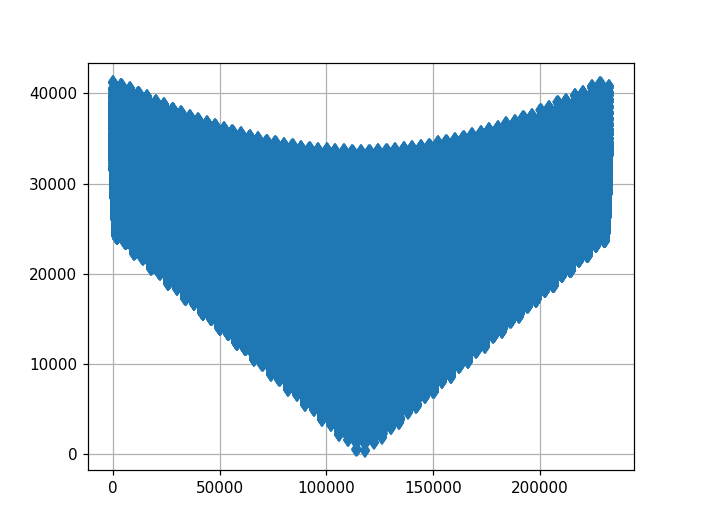

In [8]:
plt.figure()
plt.plot(Taus[0,0],'d')
plt.grid()
plt.show()

In [21]:
Taus[0,1]

array([  301.4436 ,   411.34286,   528.08295, ..., 41142.246  ,
       41302.82   , 41302.82   ], dtype=float32)

In [24]:
RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_src, pos_rcv, nb_img, Tmax, Tw, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

<IPython.core.display.Javascript object>


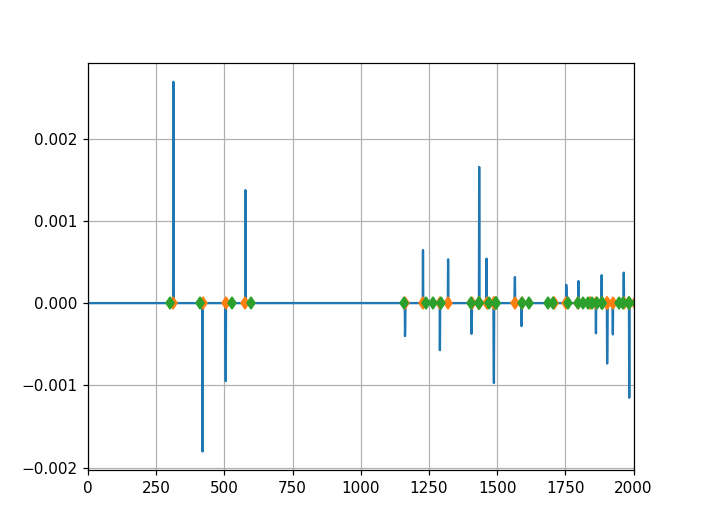

In [32]:
t = np.arange(int(ceil(Tmax * fs))) / fs
plt.figure()
plt.plot(RIRs[0,0,:])
plt.plot(Taus[0,0],[0]*len(Taus[0,0]),'d')
plt.plot(Taus[0,1],[0]*len(Taus[0,1]),'d')
plt.xlim([0,2000])
plt.grid()
plt.show()

In [8]:
Nfft = 256 #int(4e-3 * fs)
Nhop = Nfft >>2
print(Nfft,Nhop, 1000*Nfft/fs)


256 64 2.6666666666666665


<IPython.core.display.Javascript object>


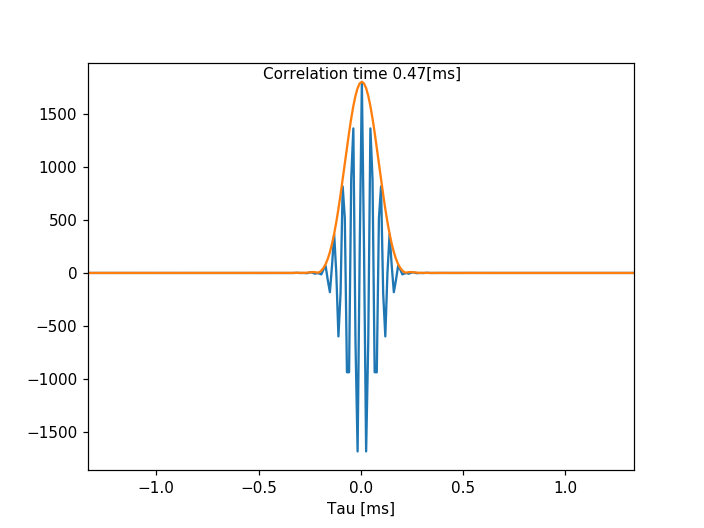

<IPython.core.display.Javascript object>


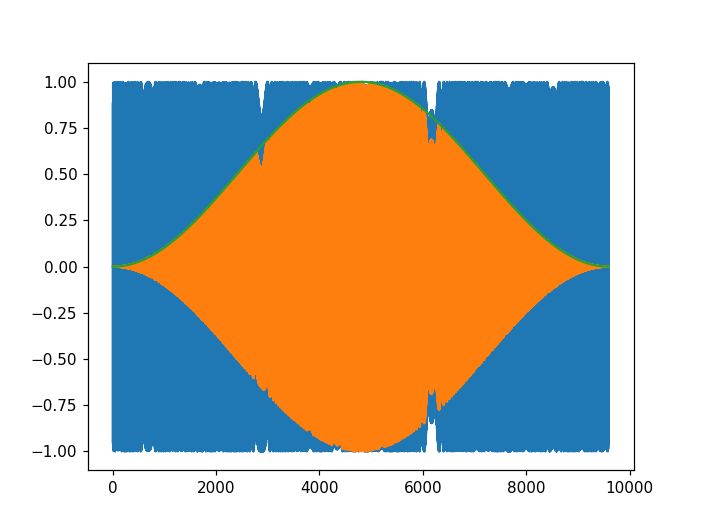

<IPython.core.display.Javascript object>


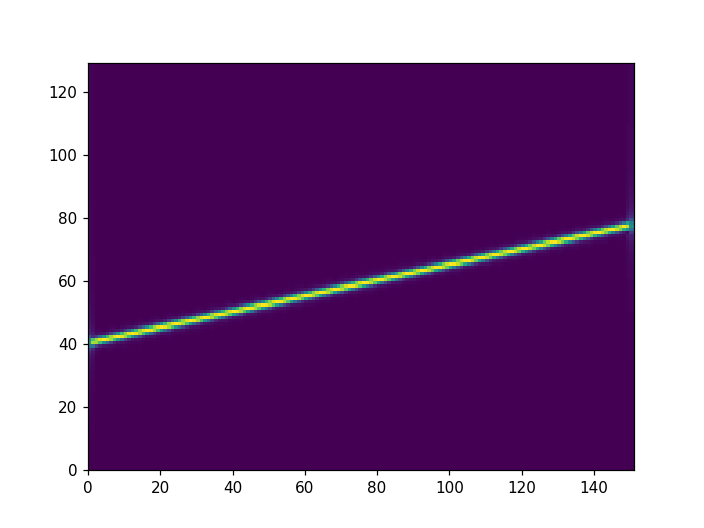

In [174]:
## Logchirp
t_probe = 0.1
t = np.arange(int(ceil(t_probe * fs))) / fs
t -= np.mean(t)

def envelope(sig_in): return np.abs(signal.hilbert(sig_in))


probe_sig = signal.chirp(t,22000,t_probe,36000,method="linear")
window = signal.windows.hann(len(probe_sig))
probe_windowed = window*probe_sig
probe_corr = signal.correlate(probe_windowed,probe_windowed,'same')
probe_env = envelope(probe_corr)



m1 = np.sum(t*np.abs(probe_env))/np.sum(np.abs(probe_env))
m2 = np.sqrt(np.sum( ((t-m1)**2)*np.abs(probe_env))/np.sum(np.abs(probe_env)))

plt.figure()
plt.plot(1000*t,probe_corr)
plt.plot(1000*t,np.abs(probe_env))
plt.text(1000*m1,np.max(np.abs(probe_env)),"Correlation time {0:.2f}[ms]".format(6*m2*1000),\
         horizontalalignment='center',verticalalignment='bottom')
plt.xlim([-1000*Nfft/2/fs,1000*Nfft/2/fs])
plt.xlabel('Tau [ms]')

plt.figure()
plt.plot(probe_sig)
plt.plot(probe_windowed)
plt.plot(window)

_,_,probe_stft = signal.stft(probe_sig,fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=True)

plt.figure()
plt.pcolormesh(np.abs(probe_stft))
plt.show()





<IPython.core.display.Javascript object>


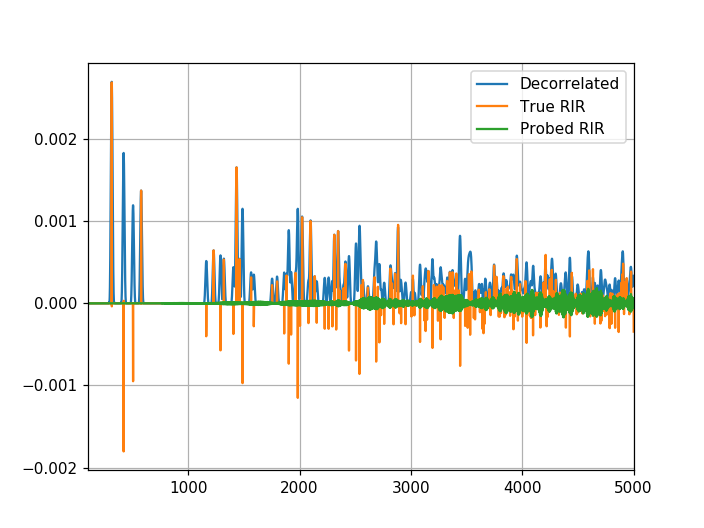

In [176]:
df = ps.DataFrame(columns={"Source","Receivers","RIR","pRIR","Dcorrelated","stft_RIR","stft_pRIR"})
normed_probe_windowed = probe_windowed / np.linalg.norm(probe_windowed)
for src in range(nb_src):
    for rcv in range(nb_rcv):
        prir = signal.convolve(RIRs[src,rcv,:],normed_probe_windowed,'full',method="direct")
        stft_rir = signal.stft(RIRs[src,rcv,:],fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
        stft_prir = signal.stft(prir,fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
        decorrelated = np.flip(signal.convolve(np.flip(prir),normed_probe_windowed))[len(normed_probe_windowed)-1:]
        
        df = df.append({"Source":src,"Receivers":rcv,"RIR":RIRs[src,rcv,:],"pRIR":prir,
                       "stft_RIR":stft_rir,"stft_pRIR":stft_prir, "Dcorrelated":decorrelated},ignore_index=True)
plt.figure()
plt.plot(envelope(df.iloc[0].Dcorrelated),label="Decorrelated")
plt.plot(df.iloc[0].RIR,label="True RIR")
plt.plot(df.iloc[0].pRIR,label="Probed RIR")

plt.xlim([100,5000])
plt.legend()
plt.grid()
plt.show()

In [ ]:
f,t,ft_r1 = signal.stft(RIRs[0,0,:],fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
_,_,ft_r2 = signal.stft(RIRs[0,1,:],fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)


In [69]:
f,t,ft_r1 = signal.stft(RIRs[0,0,:],fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
_,_,ft_r2 = signal.stft(RIRs[0,1,:],fs=fs,nperseg=Nfft,noverlap=Nfft-Nhop,return_onesided=False)
cc = ft_r1 * ft_r2.conj() / (1e-6 + np.abs(ft_r1)*np.abs(ft_r2))
print(cc.shape)

(256, 1501)


<IPython.core.display.Javascript object>


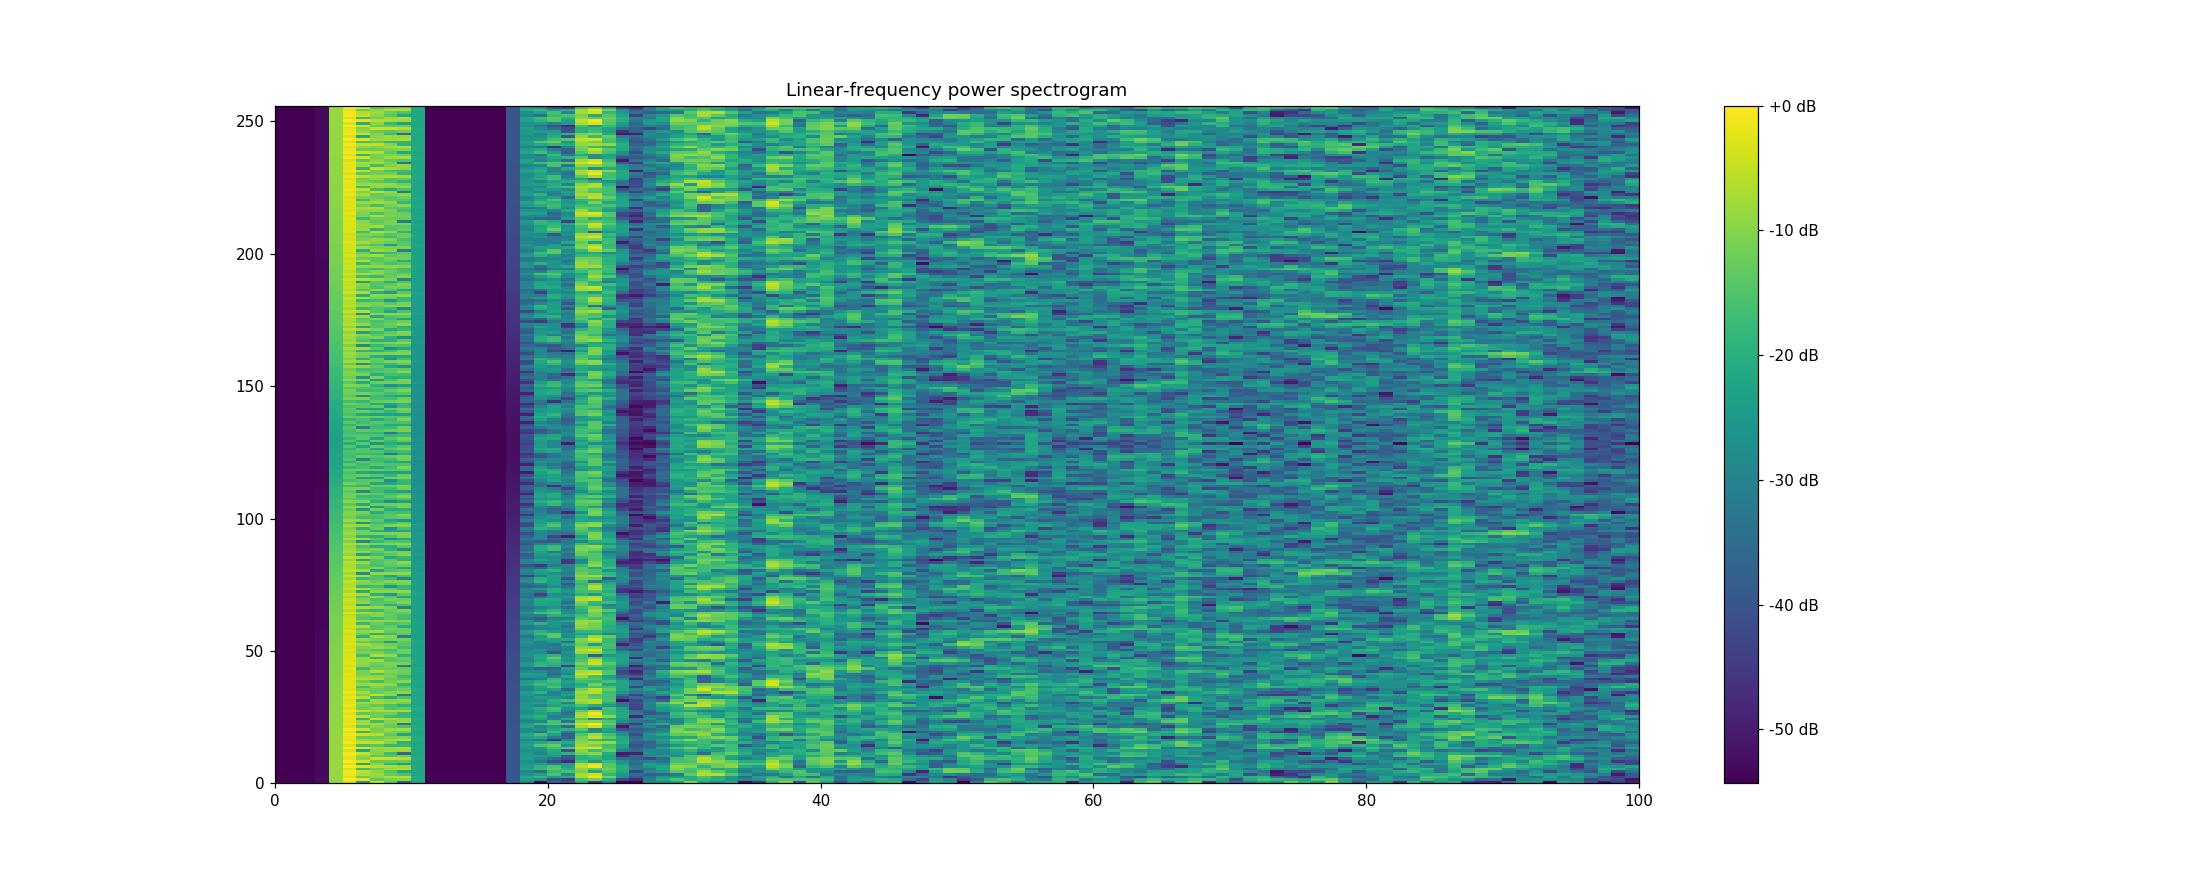

[]

In [70]:
D = 20*np.log10(np.abs(cc) + 1e-6)
D -= np.max(D)
D = D[:,:100]

plt.figure(figsize=(20,8))
plt.pcolormesh(D)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.plot()

<IPython.core.display.Javascript object>


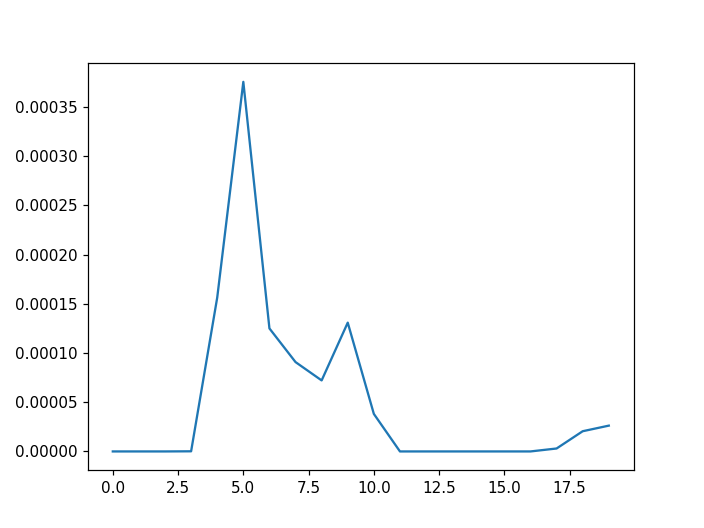

In [72]:
plt.figure()
plt.plot(np.abs(cc[50,:20]))
plt.show()

In [13]:
## Make one sided
cc_hilb  = cc.copy()
cc_hilb[:1+(Nfft>>1),:] = 0#-1j*cc_hilb[:1+(Nfft>>1),:]

(192, 1000)


/home/emilw/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1445: UserWarning: NOLA condition failed, STFT may not be invertible
  warnings.warn("NOLA condition failed, STFT may not be invertible")


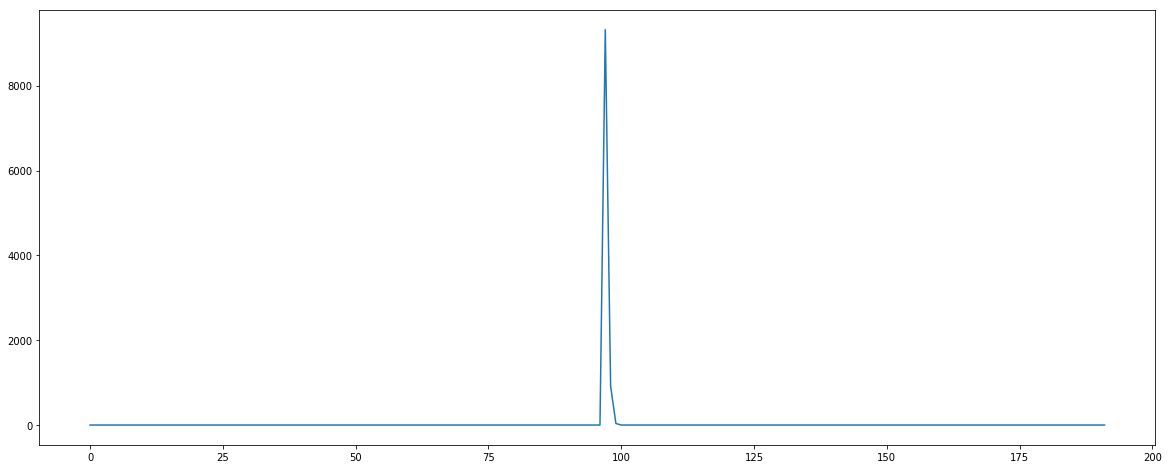

In [14]:
_,icc = signal.istft(cc,fs=fs,nperseg=Nfft,noverlap=0,input_onesided = False)

icc = icc.reshape(-1,Nfft).T
print(icc.shape)

plt.figure(figsize=(20,8))
plt.plot(np.abs(icc[:,11]))
# plt.plot(np.real(icc[:,3]))
# plt.plot(np.imag(icc[:,3]))
plt.show()




# plt.figure(figsize=(20,8))
# plt.plot(icc[:,:20])

# plt.show()

In [15]:
icc.sh

AttributeError: 'numpy.ndarray' object has no attribute 'sh'